In [0]:
import time

import numpy as np
import tensorflow as tf

import utils

### Load wikipedia articles 

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [00:34, 905kB/s]                            


## Preprocessing


In [4]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [5]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

Total words: 16680599
Unique words: 63641


## Subsampling


In [0]:
from collections import Counter

words_count = Counter(int_words)
t = 1e-4
total_count = len(int_words)
freqs = {word: count/total_count for word, count in words_count.items()}
probs = {word: 1-(t/freqs[word])**0.5 for word in words_count}
train_words = [word for word in int_words if np.random.random()<1-probs[word]]

## Making batches

In [0]:
def get_target(words, idx, window_size=5):
    
    num = np.random.randint(1, window_size+1)
    start = idx-num if idx-num>0 else 0
    end = idx+num if idx+num<len(words) else -1
    targets = set(words[start:idx]+words[idx:end])
    return list(targets)

In [0]:
def get_batches(words, batch_size, window_size=5):

    n_batches = len(words)//batch_size
    

    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y


## Building the graph


In [0]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name="inputs")
    labels = tf.placeholder(tf.int32, [None, None], name="labels")

## Embedding



In [0]:
n_vocab = len(int_to_vocab)
n_embedding =  200
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1 , 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



In [0]:
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))# create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed, 
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation


In [0]:
import random
with train_graph.as_default():
    valid_size = 16 
    valid_window = 100
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [0]:
!mkdir checkpoints

## Training



In [14]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 6.3806 0.0295 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 6.2097 0.0203 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 6.0809 0.0204 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.9949 0.0203 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.8232 0.0201 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.7705 0.0201 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.7075 0.0204 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5750 0.0202 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4029 0.0202 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.2914 0.0202 sec/batch
Nearest to have: convolution, twenty, christian, scotland, motorway, entirely, founded, no,
Nearest to many: subtypes, chd, consequently, contemporaries, evangelische, fades, encyclical, period,
Nearest to also: rom, ranch, toad, rosh, armada, assembler, medina, hiiumaa,
Nearest to time: words, bea

In [15]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

W0804 15:26:58.414682 140105449641856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


## Visualizing the word vectors



In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

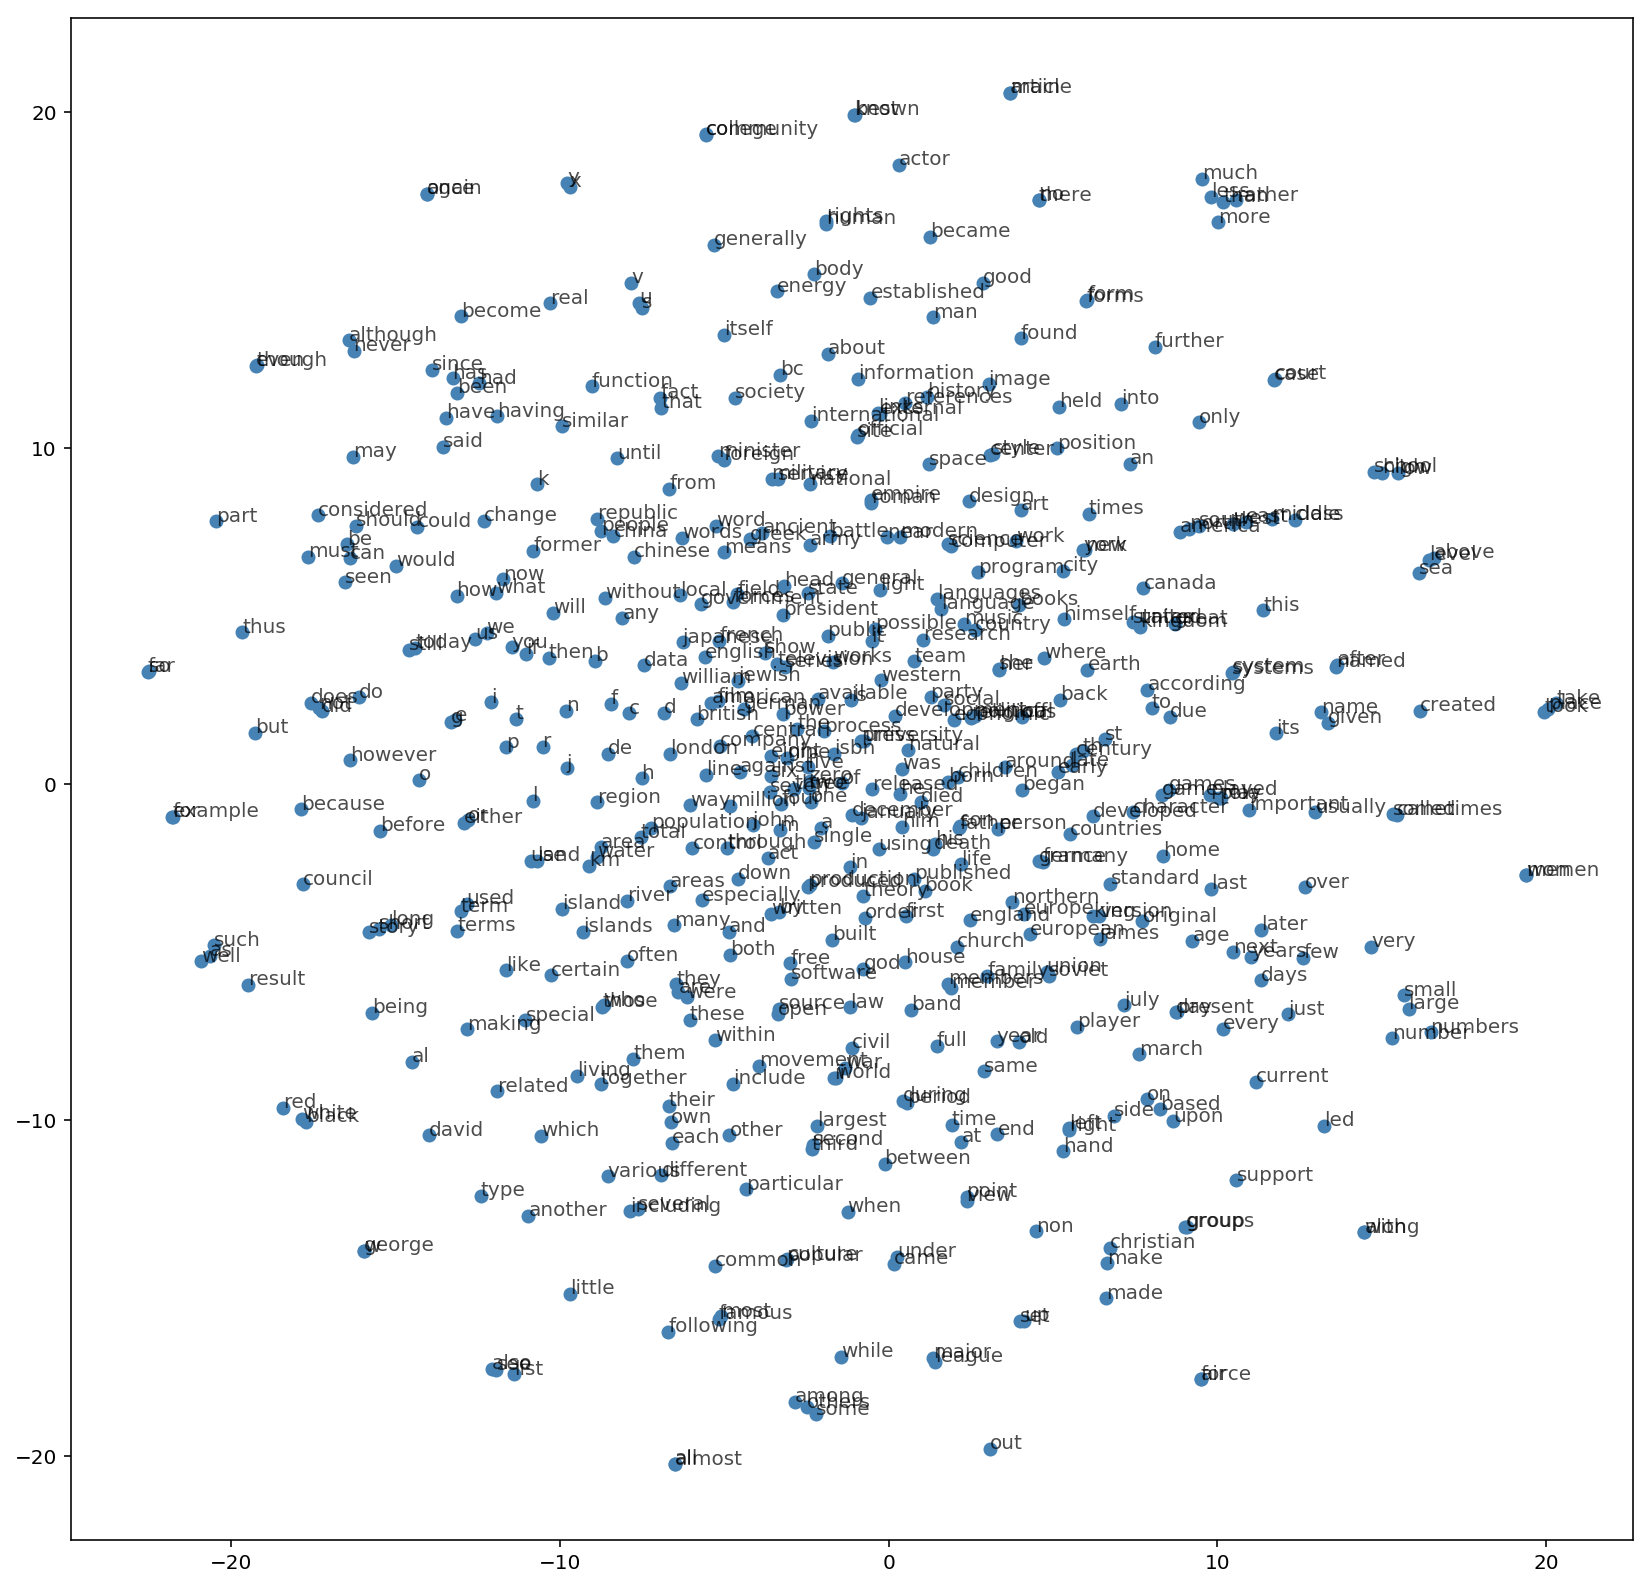

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)